# Deep Learning Pipeline with K-Fold Cross-Validation

**Autoencoder + MLP for cancer classification using pathway expression data**

This notebook implements:
- K-Fold CV (4 folds) with proper feature selection per fold
- Autoencoder for dimensionality reduction (pathways → 20D latent space)
- MLP classifier for cancer vs non-cancer prediction
- Comparison with ML baselines (Logistic Regression, Random Forest, XGBoost)

## Data Leakage Fix

**Important**: Feature selection (SelectFpr) is now performed INSIDE each K-Fold split to prevent data leakage.

Previous approach (incorrect):
- Feature selection on full dataset → K-Fold split
- Test set influenced selection → overoptimistic results

Current approach (correct):
- K-Fold split → Feature selection on train only per fold
- Test set completely independent → true generalization

In [25]:
# Imports
import time
run_start = time.time()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, SelectFpr, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [26]:
# Device configuration
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
torch.manual_seed(42)
np.random.seed(42)

## 1. Configuration

In [27]:
CONFIG = {
    # Data
    'data_file': '/Users/fanny/Desktop/Projet_DL/nagenes_work/nagenes_work_2/2_Mapped_pathways_matrices/complete_selected_pathways_matrix_cancer.csv', 
    'random_seed': 42,
    
    # Feature selection (per fold, prevents data leakage)
    'feature_selection_method': 'fpr',
    'fpr_alpha': 0.05,
    'min_features': 30,
    'max_features': 100,
    
    # K-Fold
    'n_splits': 4,
    'shuffle': True,
    'stratify': True,
    
    # Autoencoder
    'ae_latent_dim': 20,
    'ae_hidden_dim': 32,
    'ae_lr': 0.001,
    'ae_epochs': 100,
    'ae_batch_size': 16,
    'ae_patience': 30,
    
    # MLP
    'mlp_hidden_dims': [64, 32],
    'mlp_dropout': 0.3,
    'mlp_lr': 0.001,
    'mlp_epochs': 100,
    'mlp_batch_size': 16,
    'mlp_patience': 30,
}

## 1.5. Configurations Expérimentales

Tester différentes configurations pour améliorer les performances

In [28]:
# # ============================================================================
# # CONFIGURATIONS EXPÉRIMENTALES
# # ============================================================================

# CONFIGS_TO_TEST = {
#     'baseline': CONFIG,  # Configuration actuelle
    
#     # Config 1: Plus de features
#     'more_features': {
#         **CONFIG,
#         'min_features': 50,
#         'max_features': 200,
#         'ae_latent_dim': 32,  # Plus de features → plus de latent dim
#     },
    
#     # Config 2: Architecture plus profonde
#     'deeper_network': {
#         **CONFIG,
#         'ae_hidden_dim': 64,
#         'ae_latent_dim': 32,
#         'mlp_hidden_dims': [128, 64, 32],
#         'mlp_batch_size': 32,  # Plus stable avec plus de layers
#     },
    
#     # Config 3: Architecture très profonde
#     'very_deep': {
#         **CONFIG,
#         'min_features': 100,
#         'max_features': 200,
#         'ae_hidden_dim': 128,
#         'ae_latent_dim': 32,
#         'mlp_hidden_dims': [256, 128, 64, 32],
#         'mlp_batch_size': 32,
#         'mlp_dropout': 0.4,  # Plus de dropout pour réseau plus grand
#     },
    
#     # Config 4: Plus de features + FPR plus strict
#     'strict_features': {
#         **CONFIG,
#         'fpr_alpha': 0.01,  # Plus strict (moins de features mais plus significatives)
#         'min_features': 50,
#         'max_features': 150,
#         'mlp_hidden_dims': [128, 64, 32],
#         'mlp_batch_size': 32,
#     },
    
#     # Config 5: Plus de features + FPR plus permissif
#     'permissive_features': {
#         **CONFIG,
#         'fpr_alpha': 0.1,  # Plus permissif (plus de features)
#         'min_features': 100,
#         'max_features': 300,
#         'ae_latent_dim': 40,
#         'mlp_hidden_dims': [128, 64, 32],
#         'mlp_batch_size': 32,
#     },
# }

# print("="*70)
# print("🔬 CONFIGURATIONS EXPÉRIMENTALES")
# print("="*70)
# for name, config in CONFIGS_TO_TEST.items():
#     print(f"\n{name}:")
#     print(f"  Features: {config['min_features']}-{config['max_features']} (alpha={config['fpr_alpha']})")
#     print(f"  Autoencoder: {config['ae_hidden_dim']}→{config['ae_latent_dim']}")
#     print(f"  MLP: {config['mlp_hidden_dims']}")
#     print(f"  Batch size: {config['mlp_batch_size']}, Dropout: {config['mlp_dropout']}")

In [29]:
# # ============================================================================
# # FONCTION POUR TESTER TOUTES LES CONFIGURATIONS
# # ============================================================================

# def run_experiment(config_name, config, X_data, y_data, use_autoencoder=True):
#     """
#     Exécute une expérience complète avec une configuration donnée
    
#     Args:
#         config_name: Nom de la configuration
#         config: Dictionnaire de configuration
#         X_data: Features
#         y_data: Labels
#         use_autoencoder: Utiliser l'autoencoder ou non
    
#     Returns:
#         results: Résultats de l'expérience
#     """
#     print(f"\n{'='*70}")
#     print(f"🧪 EXPÉRIENCE: {config_name}")
#     print(f"{'='*70}")
#     print(f"Features: {config['min_features']}-{config['max_features']}")
#     print(f"Autoencoder: {config['ae_hidden_dim']}→{config['ae_latent_dim']}")
#     print(f"MLP: {config['mlp_hidden_dims']}")
#     print(f"Autoencoder activé: {use_autoencoder}")
    
#     # Lancer K-Fold CV
#     fold_results = run_kfold(X_data, y_data, config, use_autoencoder=use_autoencoder)
#     metrics = extract_metrics(fold_results)
    
#     # Afficher résultats
#     acc_mean = np.mean(metrics['accuracies'])
#     acc_std = np.std(metrics['accuracies'])
#     f1_mean = np.mean(metrics['f1s'])
#     f1_std = np.std(metrics['f1s'])
    
#     print(f"\n✅ RÉSULTATS:")
#     print(f"   Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
#     print(f"   F1-Score: {f1_mean:.4f} ± {f1_std:.4f}")
    
#     return {
#         'config_name': config_name,
#         'config': config,
#         'fold_results': fold_results,
#         'metrics': metrics,
#         'accuracy_mean': acc_mean,
#         'accuracy_std': acc_std,
#         'f1_mean': f1_mean,
#         'f1_std': f1_std
#     }


# # ============================================================================
# # LANCER TOUTES LES EXPÉRIENCES (AVEC AUTOENCODER)
# # ============================================================================

# print("\n" + "="*70)
# print("🚀 LANCEMENT DES EXPÉRIENCES")
# print("="*70)
# print("\n⏱️ Estimation: ~5-15 min par configuration (selon la taille)")
# print("💡 Conseil: Commencez par 1-2 configs pour tester")

# all_experiments = {}

# # Choisir quelles configs tester (décommentez celles que vous voulez)
# configs_to_run = [
#     'baseline',           # ~2-3 min
#     'more_features',      # ~3-5 min
#     'deeper_network',     # ~3-5 min
#     # 'very_deep',        # ~5-10 min (réseau très grand)
#     # 'strict_features',  # ~3-5 min
#     # 'permissive_features', # ~5-10 min (beaucoup de features)
# ]

# for config_name in configs_to_run:
#     config = CONFIGS_TO_TEST[config_name]
#     results = run_experiment(config_name, config, X, y, use_autoencoder=True)
#     all_experiments[config_name] = results

# print("\n" + "="*70)
# print("✅ TOUTES LES EXPÉRIENCES TERMINÉES")
# print("="*70)

In [30]:
# # ============================================================================
# # COMPARAISON DES EXPÉRIENCES
# # ============================================================================

# print("\n" + "="*70)
# print("📊 COMPARAISON DES EXPÉRIENCES")
# print("="*70)

# # Tableau de comparaison
# print(f"\n{'Config':<20} {'Accuracy':<18} {'F1-Score':<18} {'Features':<15}")
# print("-"*71)

# for name, exp in all_experiments.items():
#     config = exp['config']
#     print(f"{name:<20} "
#           f"{exp['accuracy_mean']:.4f} ± {exp['accuracy_std']:.4f}   "
#           f"{exp['f1_mean']:.4f} ± {exp['f1_std']:.4f}   "
#           f"{config['min_features']}-{config['max_features']}")

# # Trouver la meilleure
# best_exp_name = max(all_experiments.items(), 
#                      key=lambda x: x[1]['accuracy_mean'])[0]
# best_exp = all_experiments[best_exp_name]

# print(f"\n🏆 MEILLEURE CONFIGURATION: {best_exp_name}")
# print(f"   Accuracy: {best_exp['accuracy_mean']:.4f} ± {best_exp['accuracy_std']:.4f}")
# print(f"   F1-Score: {best_exp['f1_mean']:.4f} ± {best_exp['f1_std']:.4f}")

# # Amélioration vs baseline
# if 'baseline' in all_experiments and best_exp_name != 'baseline':
#     baseline_acc = all_experiments['baseline']['accuracy_mean']
#     improvement = best_exp['accuracy_mean'] - baseline_acc
#     print(f"\n💡 Amélioration vs baseline: {improvement:+.4f} ({improvement*100:+.2f}%)")


# # ============================================================================
# # VISUALISATION
# # ============================================================================

# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# # 1. Boxplot des accuracies
# ax = axes[0]
# data_to_plot = [exp['metrics']['accuracies'] for exp in all_experiments.values()]
# labels = list(all_experiments.keys())

# bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True, showmeans=True)
# for i, patch in enumerate(bp['boxes']):
#     if labels[i] == best_exp_name:
#         patch.set_facecolor('gold')
#     else:
#         patch.set_facecolor('lightblue')
#     patch.set_alpha(0.7)

# ax.set_ylabel('Test Accuracy', fontsize=12)
# ax.set_title('Comparaison des Configurations', fontsize=14, fontweight='bold')
# ax.grid(True, alpha=0.3, axis='y')
# ax.set_xticklabels(labels, rotation=30, ha='right')

# # 2. Bar chart accuracy moyenne
# ax = axes[1]
# accs = [exp['accuracy_mean'] for exp in all_experiments.values()]
# stds = [exp['accuracy_std'] for exp in all_experiments.values()]
# colors = ['gold' if name == best_exp_name else 'steelblue' 
#           for name in all_experiments.keys()]

# bars = ax.bar(range(len(labels)), accs, yerr=stds, 
#                color=colors, alpha=0.7, capsize=5)

# ax.set_xticks(range(len(labels)))
# ax.set_xticklabels(labels, rotation=30, ha='right')
# ax.set_ylabel('Accuracy moyenne', fontsize=12)
# ax.set_title('Performance par Configuration', fontsize=14, fontweight='bold')
# ax.set_ylim([min(accs) - 0.05, max(accs) + 0.05])
# ax.grid(True, alpha=0.3, axis='y')

# # Ajouter les valeurs
# for i, (bar, acc, std) in enumerate(zip(bars, accs, stds)):
#     ax.text(i, acc + std + 0.01, f'{acc:.4f}', 
#             ha='center', fontsize=10, fontweight='bold')

# plt.tight_layout()
# plt.show()

# # ============================================================================
# # DÉTAILS DE LA MEILLEURE CONFIG
# # ============================================================================

# print("\n" + "="*70)
# print(f"🔍 DÉTAILS: {best_exp_name}")
# print("="*70)
# best_config = best_exp['config']
# print("\nHyperparamètres:")
# print(f"  • Feature selection:")
# print(f"    - Alpha: {best_config['fpr_alpha']}")
# print(f"    - Range: {best_config['min_features']}-{best_config['max_features']} features")
# print(f"  • Autoencoder:")
# print(f"    - Architecture: {best_config['ae_hidden_dim']}→{best_config['ae_latent_dim']}")
# print(f"    - LR: {best_config['ae_lr']}, Batch: {best_config['ae_batch_size']}")
# print(f"  • MLP:")
# print(f"    - Architecture: {best_config['mlp_hidden_dims']}")
# print(f"    - Dropout: {best_config['mlp_dropout']}")
# print(f"    - LR: {best_config['mlp_lr']}, Batch: {best_config['mlp_batch_size']}")

# print("\nPerformance par fold:")
# for i, acc in enumerate(best_exp['metrics']['accuracies'], 1):
#     print(f"  Fold {i}: {acc:.4f}")

## 2. Data Loading

In [31]:
# data_folder = Path(".")
data_folder = Path("3_Prepro_pathways_select_matrices")

# data_df = pd.read_csv(data_folder / CONFIG['data_file'], index_col=0)
data_df = pd.read_csv(data_folder / "wholedata_selectedpathways_matrix_surv.csv", index_col=0)

print(f"Data shape: {data_df.shape}")
print(f"Columns: {list(data_df.columns[:10])}")

# Define metadata and label columns
labels = ['cancer_label', 'survival_label']
meta_cols = ['years_to_death', 'days_to_death', 'sample_type', 'patient', 'age_at_index', 'vital_status', 
             'sex_female', 'sex_male', 
             "stage_'--", 'stage_Stage 0', 'stage_Stage I', 
             'stage_Stage II', 'stage_Stage III', 'stage_Stage IIIA', 'stage_Stage IIIB', 'stage_Stage IIIC', 
             'stage_Stage IV', 
             "grade_'--", 'grade_G1', 'grade_G2', 'grade_G3', 'grade_G4'] 
# Define metadata to be used as features for survival prediction. They are one-hot encoded
feat_meta_cols = ['age_at_index',
             'sex_female', 'sex_male', 
             "stage_'--", 'stage_Stage 0', 'stage_Stage I', 
             'stage_Stage II', 'stage_Stage III', 'stage_Stage IIIA', 'stage_Stage IIIB', 'stage_Stage IIIC', 
             'stage_Stage IV', 
             "grade_'--", 'grade_G1', 'grade_G2', 'grade_G3', 'grade_G4'] 

label_cols = meta_cols + labels

# Extract gene columns
pathw_cols = [col for col in data_df.columns if col not in label_cols]

X = data_df[pathw_cols + feat_meta_cols].values
y = data_df['survival_label'].values

print(f"\nLabel column: 'survival_label'")
print(f"Label distribution:\n{pd.Series(y).value_counts()}")
print(f"\nGenes: {len(pathw_cols)}")
print(f"Samples: {X.shape[0]}")

# Check for NaN
nan_count = np.isnan(X).sum()
if nan_count > 0:
    print(f"Replacing {nan_count} NaN values with 0")
    X = np.nan_to_num(X, nan=0.0)

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

Data shape: (160, 374)
Columns: ['B Cell Proliferation (GO:0042100)', 'DNA Damage Checkpoint Signaling (GO:0000077)', 'DNA Damage Response (GO:0006974)', 'DNA Damage Response, Signal Transduction By P53 Class Mediator (GO:0030330)', 'DNA Damage Response, Signal Transduction By P53 Class Mediator Resulting In Cell Cycle Arrest (GO:0006977)', 'DNA Damage Response, Signal Transduction By P53 Class Mediator Resulting In Transcription Of P21 Class Mediator (GO:0006978)', 'DNA Damage Response, Signal Transduction Resulting In Transcription (GO:0042772)', 'DNA Dealkylation Involved In DNA Repair (GO:0006307)', 'DNA Integrity Checkpoint Signaling (GO:0031570)', 'DNA Repair (GO:0006281)']

Label column: 'survival_label'
Label distribution:
0.0    107
1.0     53
Name: count, dtype: int64

Genes: 350
Samples: 160


## 3. PyTorch Dataset

In [32]:
class PathwayDataset(Dataset):
    """PyTorch Dataset for pathway expression data"""
    
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).unsqueeze(1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

complete_dataset = PathwayDataset(X, y)

## 4. Model Architectures

In [33]:
class Autoencoder(nn.Module):
    """Autoencoder for dimensionality reduction: input → hidden → latent → hidden → output"""
    
    def __init__(self, input_dim, latent_dim=20, hidden_dim=32):
        super().__init__()
        
        # Encoder: input → hidden → latent
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        
        # Decoder: latent → hidden → output
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed
    
    def encode(self, x):
        """Get latent representation"""
        return self.encoder(x)

In [34]:
class SimpleMLP(nn.Module):
    """MLP classifier: latent → hidden layers → output (binary classification)"""
    
    def __init__(self, input_dim, hidden_dims=[64, 32], dropout=0.3):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        # Output layer (no activation, uses BCEWithLogitsLoss)
        layers.append(nn.Linear(prev_dim, 1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

## 5. Training Functions

In [35]:
def train_autoencoder(model, train_loader, val_loader, epochs=100, lr=0.001, patience=30):
    """Train autoencoder with early stopping"""
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)
            optimizer.zero_grad()
            reconstructed = model(X_batch)
            loss = criterion(reconstructed, X_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, _ in val_loader:
                X_batch = X_batch.to(device)
                reconstructed = model(X_batch)
                loss = criterion(reconstructed, X_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch+1}")
                break
    
    return history

In [36]:
def train_mlp(model, train_loader, val_loader, epochs=100, lr=0.001, patience=30):
    """Train MLP classifier with early stopping"""
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_acc = 0
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (preds == y_batch).sum().item()
            train_total += y_batch.size(0)
        
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        
        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.size(0)
        
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch+1}")
                break
    
    return history

In [37]:
def run_kfold(X_data, y_data, config, use_autoencoder=True):
    """K-Fold CV with feature selection per fold (prevents data leakage)"""
    import time
    from sklearn.model_selection import StratifiedKFold
    from sklearn.feature_selection import SelectFpr, SelectKBest, f_classif
    
    skf = StratifiedKFold(n_splits=config['n_splits'], shuffle=config['shuffle'], random_state=config['random_seed'])
    fold_results = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_data, y_data), 1):
        print(f"\nFold {fold}/{config['n_splits']}")
        start_time = time.time()
        
        # Split data
        X_train_full, X_test = X_data[train_idx], X_data[test_idx]
        y_train_full, y_test = y_data[train_idx], y_data[test_idx]
        
        # Feature selection
        selector = SelectFpr(f_classif, alpha=config['fpr_alpha'])
        selector.fit(X_train_full, y_train_full)
        n_selected = selector.get_support().sum()
        
        if n_selected < config['min_features']:
            selector = SelectKBest(f_classif, k=config['min_features'])
            selector.fit(X_train_full, y_train_full)
            n_selected = config['min_features']
        elif n_selected > config['max_features']:
            selector = SelectKBest(f_classif, k=config['max_features'])
            selector.fit(X_train_full, y_train_full)
            n_selected = config['max_features']
        
        X_train_selected = selector.transform(X_train_full)
        X_test_selected = selector.transform(X_test)
        
        # Split train/val
        from sklearn.model_selection import train_test_split
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_selected, y_train_full, test_size=0.2, stratify=y_train_full, random_state=config['random_seed']
        )
        
        # Create datasets
        train_dataset = PathwayDataset(X_train, y_train)
        val_dataset = PathwayDataset(X_val, y_val)
        test_dataset = PathwayDataset(X_test_selected, y_test)
        
        train_loader = DataLoader(train_dataset, batch_size=config['ae_batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config['ae_batch_size'], shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=config['ae_batch_size'], shuffle=False)
        
        # Train autoencoder
        if use_autoencoder:
            autoencoder = Autoencoder(
                input_dim=n_selected,
                latent_dim=config['ae_latent_dim'],
                hidden_dim=config['ae_hidden_dim']
            ).to(device)
            
            ae_history = train_autoencoder(
                autoencoder, train_loader, val_loader,
                epochs=config['ae_epochs'], lr=config['ae_lr'], patience=config['ae_patience']
            )
            
            # Encode data
            autoencoder.eval()
            with torch.no_grad():
                X_train_encoded = autoencoder.encode(torch.FloatTensor(X_train).to(device)).cpu().numpy()
                X_val_encoded = autoencoder.encode(torch.FloatTensor(X_val).to(device)).cpu().numpy()
                X_test_encoded = autoencoder.encode(torch.FloatTensor(X_test_selected).to(device)).cpu().numpy()
            
            train_dataset_mlp = PathwayDataset(X_train_encoded, y_train)
            val_dataset_mlp = PathwayDataset(X_val_encoded, y_val)
            test_dataset_mlp = PathwayDataset(X_test_encoded, y_test)
            mlp_input_dim = config['ae_latent_dim']
        else:
            train_dataset_mlp = train_dataset
            val_dataset_mlp = val_dataset
            test_dataset_mlp = test_dataset
            mlp_input_dim = n_selected
            autoencoder = None
            ae_history = None
        
        train_loader_mlp = DataLoader(train_dataset_mlp, batch_size=config['mlp_batch_size'], shuffle=True)
        val_loader_mlp = DataLoader(val_dataset_mlp, batch_size=config['mlp_batch_size'], shuffle=False)
        test_loader_mlp = DataLoader(test_dataset_mlp, batch_size=config['mlp_batch_size'], shuffle=False)
        
        # Train MLP
        mlp = SimpleMLP(
            input_dim=mlp_input_dim,
            hidden_dims=config['mlp_hidden_dims'],
            dropout=config['mlp_dropout']
        ).to(device)
        
        mlp_history = train_mlp(
            mlp, train_loader_mlp, val_loader_mlp,
            epochs=config['mlp_epochs'], lr=config['mlp_lr'], patience=config['mlp_patience']
        )
        
        # Evaluate
        mlp.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader_mlp:
                X_batch = X_batch.to(device)
                outputs = mlp(X_batch)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.numpy())
        
        test_metrics = {
            'accuracy': accuracy_score(all_labels, all_preds),
            'precision': precision_score(all_labels, all_preds, zero_division=0),
            'recall': recall_score(all_labels, all_preds, zero_division=0),
            'f1': f1_score(all_labels, all_preds, zero_division=0)
        }
        
        train_time = time.time() - start_time
        print(f"  Accuracy: {test_metrics['accuracy']:.4f}, Time: {train_time:.1f}s")
        
        fold_results.append({
            'fold': fold,
            'n_features_selected': n_selected,
            'selector': selector,
            'autoencoder': autoencoder,
            'mlp': mlp,
            'ae_history': ae_history,
            'mlp_history': mlp_history,
            'test_metrics': test_metrics,
            'train_time': train_time
        })
    
    return fold_results

## 6. Metrics Extraction

In [38]:
def extract_metrics(fold_results):
    """Extract metrics from fold results for easy analysis"""
    return {
        'accuracies': [r['test_metrics']['accuracy'] for r in fold_results],
        'precisions': [r['test_metrics']['precision'] for r in fold_results],
        'recalls': [r['test_metrics']['recall'] for r in fold_results],
        'f1s': [r['test_metrics']['f1'] for r in fold_results],
        'train_times': [r['train_time'] for r in fold_results]
    }

## 7. Run K-Fold CV - MLP with Autoencoder

In [39]:
fold_results_with_ae = run_kfold(X, y, CONFIG, use_autoencoder=True)
metrics_with_ae = extract_metrics(fold_results_with_ae)

print(f"\n{'='*60}")
print("RESULTS - MLP with Autoencoder")
print(f"{'='*60}")
print(f"Accuracy:  {np.mean(metrics_with_ae['accuracies']):.4f} ± {np.std(metrics_with_ae['accuracies']):.4f}")
print(f"F1-Score:  {np.mean(metrics_with_ae['f1s']):.4f} ± {np.std(metrics_with_ae['f1s']):.4f}")


Fold 1/4
  Early stopping at epoch 39
  Accuracy: 0.8000, Time: 3.2s

Fold 2/4
  Early stopping at epoch 35
  Accuracy: 0.6500, Time: 2.8s

Fold 3/4
  Early stopping at epoch 42
  Accuracy: 0.6500, Time: 3.1s

Fold 4/4
  Early stopping at epoch 48
  Accuracy: 0.8000, Time: 3.1s

RESULTS - MLP with Autoencoder
Accuracy:  0.7250 ± 0.0750
F1-Score:  0.5341 ± 0.1439


In [40]:
def run_kfold_cv(dataset, X_full, y_full, config, device):
    """
    K-Fold CV pipeline with Feature Selection, Autoencoder and MLP
    
    Feature selection is performed inside each fold to prevent data leakage.
    
    Returns:
        fold_results: List of results per fold
    """
    import time
    from sklearn.model_selection import StratifiedKFold
    from sklearn.feature_selection import SelectFpr, SelectKBest, f_classif
    
    skf = StratifiedKFold(
        n_splits=config['n_splits'], 
        shuffle=True, 
        random_state=config['random_state']
    )
    
    fold_results = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_full, y_full), 1):
        print(f"\nFold {fold}/{config['n_splits']}")
        start_time = time.time()
        
        # Split train into train + validation (80/20)
        train_size = int(0.8 * len(train_idx))
        np.random.shuffle(train_idx)
        
        actual_train_idx = train_idx[:train_size]
        val_idx = train_idx[train_size:]
        
        # Get data splits
        X_train = X_full[actual_train_idx]
        X_val = X_full[val_idx]
        X_test = X_full[test_idx]
        y_train = y_full[actual_train_idx]
        
        # Feature selection on train only
        selector = SelectFpr(f_classif, alpha=config['alpha'])
        selector.fit(X_train, y_train)
        n_selected = selector.get_support().sum()
        
        # Adjust if needed
        if n_selected < config['min_features']:
            selector = SelectKBest(f_classif, k=config['min_features'])
            selector.fit(X_train, y_train)
            n_selected = config['min_features']
        elif n_selected > config['max_features']:
            selector = SelectKBest(f_classif, k=config['max_features'])
            selector.fit(X_train, y_train)
            n_selected = config['max_features']
        
        # Get p-values
        f_scores, p_values = f_classif(X_train, y_train)
        selected_mask = selector.get_support()
        selected_p_values = p_values[selected_mask]
        
        # Transform all splits
        X_train_selected = selector.transform(X_train)
        X_val_selected = selector.transform(X_val)
        X_test_selected = selector.transform(X_test)
        
        # Create datasets
        train_dataset_selected = PathwayDataset(X_train_selected, y_train)
        val_dataset_selected = PathwayDataset(X_val_selected, y_full[val_idx])
        test_dataset_selected = PathwayDataset(X_test_selected, y_full[test_idx])
        
        train_loader = DataLoader(train_dataset_selected, batch_size=config['ae_batch_size'], 
                                  shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset_selected, batch_size=config['ae_batch_size'], 
                               shuffle=False, num_workers=0)
        test_loader = DataLoader(test_dataset_selected, batch_size=config['ae_batch_size'], 
                                shuffle=False, num_workers=0)
        
        # Train autoencoder
        autoencoder = Autoencoder(
            input_dim=n_selected,
            encoding_dim=config['ae_encoding_dim'],
            hidden_dim=config['ae_hidden_dim']
        ).to(device)
        
        autoencoder, ae_history = train_autoencoder(
            autoencoder, train_loader, val_loader, config, device
        )
        
        # Encode data
        autoencoder.eval()
        
        def encode_dataset(loader):
            encoded_data = []
            labels = []
            with torch.no_grad():
                for batch_X, batch_y in loader:
                    batch_X = batch_X.to(device)
                    encoded = autoencoder.encode(batch_X)
                    encoded_data.append(encoded.cpu())
                    labels.append(batch_y)
            return torch.cat(encoded_data), torch.cat(labels)
        
        X_train_encoded, y_train_encoded = encode_dataset(train_loader)
        X_val_encoded, y_val_encoded = encode_dataset(val_loader)
        X_test_encoded, y_test_encoded = encode_dataset(test_loader)
        
        # Create encoded datasets
        train_dataset_encoded = PathwayDataset(
            X_train_encoded.numpy(), y_train_encoded.numpy()
        )
        val_dataset_encoded = PathwayDataset(
            X_val_encoded.numpy(), y_val_encoded.numpy()
        )
        test_dataset_encoded = PathwayDataset(
            X_test_encoded.numpy(), y_test_encoded.numpy()
        )
        
        train_loader_mlp = DataLoader(train_dataset_encoded, 
                                     batch_size=config['mlp_batch_size'], 
                                     shuffle=True, num_workers=0)
        val_loader_mlp = DataLoader(val_dataset_encoded, 
                                   batch_size=config['mlp_batch_size'], 
                                   shuffle=False, num_workers=0)
        test_loader_mlp = DataLoader(test_dataset_encoded, 
                                    batch_size=config['mlp_batch_size'], 
                                    shuffle=False, num_workers=0)
        
        # Train MLP
        mlp = SimpleMLP(
            input_dim=config['ae_encoding_dim'],
            hidden_dims=config['mlp_hidden_dims'],
            dropout_rate=config['mlp_dropout']
        ).to(device)
        
        mlp, mlp_history, best_epoch = train_mlp_with_early_stopping(
            mlp, train_loader_mlp, val_loader_mlp, config, device
        )
        
        # Evaluate
        test_metrics = evaluate_model(mlp, test_loader_mlp, device)
        
        train_time = time.time() - start_time
        print(f"  Accuracy: {test_metrics['accuracy']:.4f}, Time: {train_time:.1f}s")
        
        # Store results
        fold_results.append({
            'fold': fold,
            'selector': selector,
            'selected_features': selector.get_support(),
            'n_selected': n_selected,
            'selected_p_values': selected_p_values,
            'autoencoder': autoencoder,
            'mlp': mlp,
            'ae_history': ae_history,
            'mlp_history': mlp_history,
            'best_epoch': best_epoch,
            'test_metrics': test_metrics,
            'train_time': train_time
        })
    
    return fold_results


In [41]:
def run_kfold_cv_no_autoencoder(dataset, X_full, y_full, config, device):
    """
    K-Fold CV pipeline WITHOUT Autoencoder (MLP on pathways directly)
    
    Feature selection is performed inside each fold to prevent data leakage.
    
    Returns:
        fold_results: List of results per fold
    """
    import time
    from sklearn.model_selection import StratifiedKFold
    from sklearn.feature_selection import SelectFpr, SelectKBest, f_classif
    
    skf = StratifiedKFold(
        n_splits=config['n_splits'], 
        shuffle=True, 
        random_state=config['random_state']
    )
    
    fold_results = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_full, y_full), 1):
        print(f"\nFold {fold}/{config['n_splits']}")
        start_time = time.time()
        
        # Split train into train + validation (80/20)
        train_size = int(0.8 * len(train_idx))
        np.random.shuffle(train_idx)
        
        actual_train_idx = train_idx[:train_size]
        val_idx = train_idx[train_size:]
        
        # Get data splits
        X_train = X_full[actual_train_idx]
        X_val = X_full[val_idx]
        X_test = X_full[test_idx]
        y_train = y_full[actual_train_idx]
        
        # Feature selection on train only
        selector = SelectFpr(f_classif, alpha=config['alpha'])
        selector.fit(X_train, y_train)
        n_selected = selector.get_support().sum()
        
        # Adjust if needed
        if n_selected < config['min_features']:
            selector = SelectKBest(f_classif, k=config['min_features'])
            selector.fit(X_train, y_train)
            n_selected = config['min_features']
        elif n_selected > config['max_features']:
            selector = SelectKBest(f_classif, k=config['max_features'])
            selector.fit(X_train, y_train)
            n_selected = config['max_features']
        
        # Get p-values
        f_scores, p_values = f_classif(X_train, y_train)
        selected_mask = selector.get_support()
        selected_p_values = p_values[selected_mask]
        
        # Transform all splits
        X_train_selected = selector.transform(X_train)
        X_val_selected = selector.transform(X_val)
        X_test_selected = selector.transform(X_test)
        
        # Create datasets
        train_dataset_selected = PathwayDataset(X_train_selected, y_train)
        val_dataset_selected = PathwayDataset(X_val_selected, y_full[val_idx])
        test_dataset_selected = PathwayDataset(X_test_selected, y_full[test_idx])
        
        train_loader = DataLoader(train_dataset_selected, batch_size=config['mlp_batch_size'], 
                                  shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset_selected, batch_size=config['mlp_batch_size'], 
                               shuffle=False, num_workers=0)
        test_loader = DataLoader(test_dataset_selected, batch_size=config['mlp_batch_size'], 
                                shuffle=False, num_workers=0)
        
        # Train MLP directly on selected features
        mlp = SimpleMLP(
            input_dim=n_selected,
            hidden_dims=config['mlp_hidden_dims'],
            dropout_rate=config['mlp_dropout']
        ).to(device)
        
        mlp, mlp_history, best_epoch = train_mlp_with_early_stopping(
            mlp, train_loader, val_loader, config, device
        )
        
        # Evaluate
        test_metrics = evaluate_model(mlp, test_loader, device)
        
        train_time = time.time() - start_time
        print(f"  Accuracy: {test_metrics['accuracy']:.4f}, Time: {train_time:.1f}s")
        
        # Store results
        fold_results.append({
            'fold': fold,
            'selector': selector,
            'selected_features': selector.get_support(),
            'n_selected': n_selected,
            'selected_p_values': selected_p_values,
            'mlp': mlp,
            'mlp_history': mlp_history,
            'best_epoch': best_epoch,
            'test_metrics': test_metrics,
            'train_time': train_time
        })
    
    return fold_results


## 8. Run K-Fold CV - MLP without Autoencoder

In [42]:
fold_results_no_ae = run_kfold(X, y, CONFIG, use_autoencoder=False)
metrics_no_ae = extract_metrics(fold_results_no_ae)

print(f"\n{'='*60}")
print("RESULTS - MLP without Autoencoder")
print(f"{'='*60}")
print(f"Accuracy:  {np.mean(metrics_no_ae['accuracies']):.4f} ± {np.std(metrics_no_ae['accuracies']):.4f}")
print(f"F1-Score:  {np.mean(metrics_no_ae['recalls']):.4f} ± {np.std(metrics_no_ae['recalls']):.4f}")


Fold 1/4
  Early stopping at epoch 44
  Accuracy: 0.7000, Time: 2.0s

Fold 2/4
  Early stopping at epoch 42
  Accuracy: 0.6750, Time: 1.9s

Fold 3/4
  Early stopping at epoch 36
  Accuracy: 0.7000, Time: 1.6s

Fold 4/4
  Early stopping at epoch 50
  Accuracy: 0.5750, Time: 2.4s

RESULTS - MLP without Autoencoder
Accuracy:  0.6625 ± 0.0515
F1-Score:  0.4162 ± 0.1302


## 9. Comparison: With vs Without Autoencoder


COMPARISON: With vs Without AE

Metric          With AE              Without AE           Diff      
-----------------------------------------------------------------
Accuracy        0.7250 ± 0.0750   0.6625 ± 0.0515   +0.0625
F1-Score        0.5341 ± 0.1439   0.4408 ± 0.0996   +0.0933


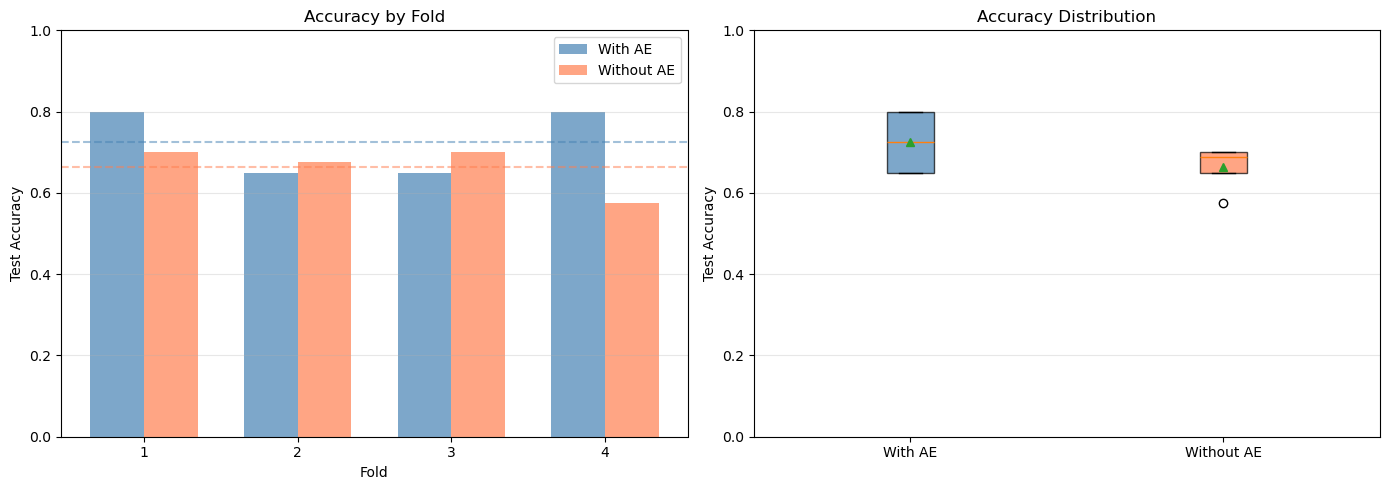

In [43]:
print(f"\n{'='*60}")
print("COMPARISON: With vs Without AE")
print(f"{'='*60}")

print(f"\n{'Metric':<15} {'With AE':<20} {'Without AE':<20} {'Diff':<10}")
print("-"*65)

def print_comparison(metric_name, values_with, values_no):
    mean_with = np.mean(values_with)
    std_with = np.std(values_with)
    mean_no = np.mean(values_no)
    std_no = np.std(values_no)
    diff = mean_with - mean_no
    print(f"{metric_name:<15} {mean_with:.4f} ± {std_with:.4f}   "
          f"{mean_no:.4f} ± {std_no:.4f}   {diff:+.4f}")

print_comparison("Accuracy", metrics_with_ae['accuracies'], metrics_no_ae['accuracies'])
print_comparison("F1-Score", metrics_with_ae['f1s'], metrics_no_ae['f1s'])

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy by fold
ax = axes[0]
folds = list(range(1, CONFIG['n_splits'] + 1))
x = np.arange(len(folds))
width = 0.35

bars1 = ax.bar(x - width/2, metrics_with_ae['accuracies'], width, label='With AE', color='steelblue', alpha=0.7)
bars2 = ax.bar(x + width/2, metrics_no_ae['accuracies'], width, label='Without AE', color='coral', alpha=0.7)

ax.axhline(np.mean(metrics_with_ae['accuracies']), color='steelblue', linestyle='--', alpha=0.5)
ax.axhline(np.mean(metrics_no_ae['accuracies']), color='coral', linestyle='--', alpha=0.5)

ax.set_xlabel('Fold')
ax.set_ylabel('Test Accuracy')
ax.set_title('Accuracy by Fold')
ax.set_xticks(x)
ax.set_xticklabels(folds)
ax.legend()
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')

# Boxplot
ax = axes[1]
data_to_plot = [metrics_with_ae['accuracies'], metrics_no_ae['accuracies']]
bp = ax.boxplot(data_to_plot, labels=['With AE', 'Without AE'], patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('coral')
for box in bp['boxes']:
    box.set_alpha(0.7)

ax.set_ylabel('Test Accuracy')
ax.set_title('Accuracy Distribution')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 10. ML Baselines - Import XGBoost

In [44]:
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## 11. ML Baselines - K-Fold CV

In [45]:
def run_kfold_ml_baseline(X_data, y_data, model, model_name, config):
    """K-Fold CV for sklearn models with feature selection per fold"""
    import time
    from sklearn.model_selection import StratifiedKFold
    from sklearn.feature_selection import SelectFpr, SelectKBest, f_classif
    
    skf = StratifiedKFold(n_splits=config['n_splits'], shuffle=config['shuffle'], random_state=config['random_seed'])
    fold_results = []
    
    print(f"\n{model_name} K-Fold CV:")
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_data, y_data), 1):
        print(f"  Fold {fold}/{config['n_splits']}...", end=" ", flush=True)
        start_time = time.time()
        
        X_train, X_test = X_data[train_idx], X_data[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        
        # Feature selection
        selector = SelectFpr(f_classif, alpha=config['fpr_alpha'])
        selector.fit(X_train, y_train)
        n_selected = selector.get_support().sum()
        
        if n_selected < config['min_features']:
            selector = SelectKBest(f_classif, k=config['min_features'])
            selector.fit(X_train, y_train)
            n_selected = config['min_features']
        elif n_selected > config['max_features']:
            selector = SelectKBest(f_classif, k=config['max_features'])
            selector.fit(X_train, y_train)
            n_selected = config['max_features']
        
        X_train_selected = selector.transform(X_train)
        X_test_selected = selector.transform(X_test)
        
        # Train
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        
        test_metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0)
        }
        
        train_time = time.time() - start_time
        print(f"Acc: {test_metrics['accuracy']:.4f}, Time: {train_time:.1f}s")
        
        fold_results.append({
            'fold': fold,
            'n_features_selected': n_selected,
            'model': model,
            'selector': selector,
            'test_metrics': test_metrics,
            'train_time': train_time
        })
    
    return fold_results


# Run ML baselines
lr_model = LogisticRegression(max_iter=1000, random_state=CONFIG['random_seed'])
fold_results_lr = run_kfold_ml_baseline(X, y, lr_model, "LR", CONFIG)

rf_model = RandomForestClassifier(n_estimators=50, random_state=CONFIG['random_seed'], n_jobs=-1)
fold_results_rf = run_kfold_ml_baseline(X, y, rf_model, "RF", CONFIG)

# if XGBOOST_AVAILABLE:
#     xgb_model = XGBClassifier(n_estimators=100, random_state=CONFIG['random_seed'], eval_metric='logloss')
#     fold_results_xgb = run_kfold_ml_baseline(X, y, xgb_model, "XGB", CONFIG)
# else:
#     fold_results_xgb = []


LR K-Fold CV:
  Fold 1/4... Acc: 0.6250, Time: 0.0s
  Fold 2/4... Acc: 0.7000, Time: 0.0s
  Fold 3/4... Acc: 0.6500, Time: 0.0s
  Fold 4/4... Acc: 0.6250, Time: 0.0s

RF K-Fold CV:
  Fold 1/4... Acc: 0.7500, Time: 0.2s
  Fold 2/4... Acc: 0.6750, Time: 0.2s
  Fold 3/4... Acc: 0.7250, Time: 0.2s
  Fold 4/4... Acc: 0.6250, Time: 0.2s


## 12. Global Comparison - Deep Learning vs ML Baselines


GLOBAL COMPARISON

Model                Accuracy           Recall            
--------------------------------------------------------
MLP + AE             0.7250 ± 0.0750   0.4890 ± 0.1516
MLP (no AE)          0.6625 ± 0.0515   0.4162 ± 0.1302
LR                   0.6500 ± 0.0306   0.4135 ± 0.1523
RF                   0.6937 ± 0.0480   0.3379 ± 0.1207

Best: MLP + AE (Accuracy: 0.7250)


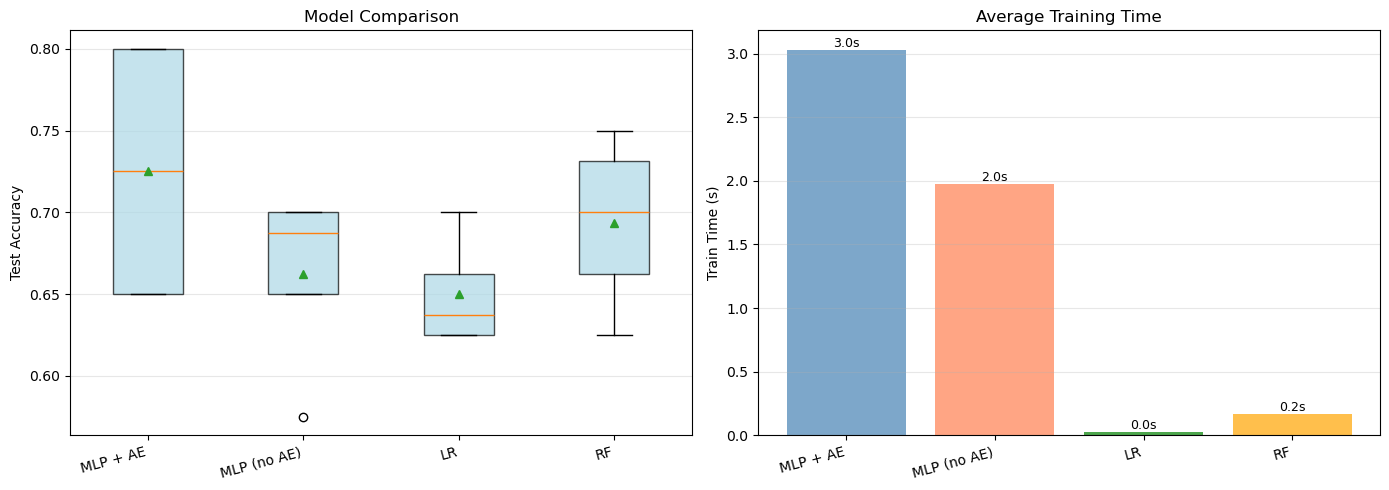

In [46]:
# Collect all metrics
all_results = {
    'MLP + AE': extract_metrics(fold_results_with_ae),
    'MLP (no AE)': extract_metrics(fold_results_no_ae),
    'LR': extract_metrics(fold_results_lr),
    'RF': extract_metrics(fold_results_rf)
}

# if XGBOOST_AVAILABLE and fold_results_xgb:
#     all_results['XGB'] = extract_metrics(fold_results_xgb)

# Comparison table
print(f"\n{'='*60}")
print("GLOBAL COMPARISON")
print(f"{'='*60}")
print(f"\n{'Model':<20} {'Accuracy':<18} {'Recall':<18}")
print("-"*56)

for model_name, metrics in all_results.items():
    acc_mean = np.mean(metrics['accuracies'])
    acc_std = np.std(metrics['accuracies'])
    recall_mean = np.mean(metrics['recalls'])
    recall_std = np.std(metrics['recalls'])
    
    print(f"{model_name:<20} {acc_mean:.4f} ± {acc_std:.4f}   "
          f"{recall_mean:.4f} ± {recall_std:.4f}")

# Find best
best_model_name = max(all_results.items(), 
                      key=lambda x: np.mean(x[1]['accuracies']))[0]
best_acc = np.mean(all_results[best_model_name]['accuracies'])

print(f"\nBest: {best_model_name} (Accuracy: {best_acc:.4f})")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
ax = axes[0]
data_to_plot = [metrics['accuracies'] for metrics in all_results.values()]
labels = list(all_results.keys())

bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True, showmeans=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

ax.set_ylabel('Test Accuracy')
ax.set_title('Model Comparison')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticklabels(labels, rotation=15, ha='right')

# Training time
ax = axes[1]
times = [np.mean(metrics['train_times']) for metrics in all_results.values()]
colors = ['steelblue', 'coral', 'green', 'orange', 'purple'][:len(times)]

bars = ax.bar(labels, times, color=colors, alpha=0.7)
ax.set_ylabel('Train Time (s)')
ax.set_title('Average Training Time')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticklabels(labels, rotation=15, ha='right')

for bar, time in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{time:.1f}s', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 13. Save Results

In [47]:
import pickle
import json
from datetime import datetime

save_dir = Path("results_kfold")
save_dir.mkdir(exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save metrics (JSON)
metrics_summary = {
    'timestamp': timestamp,
    'config': CONFIG,
    'models': {}
}

for model_name, metrics in all_results.items():
    metrics_summary['models'][model_name] = {
        'accuracy': {
            'mean': float(np.mean(metrics['accuracies'])),
            'std': float(np.std(metrics['accuracies'])),
            'values': [float(x) for x in metrics['accuracies']]
        },
        'f1': {
            'mean': float(np.mean(metrics['f1s'])),
            'std': float(np.std(metrics['f1s'])),
            'values': [float(x) for x in metrics['f1s']]
        }
    }

json_path = save_dir / f"metrics_{timestamp}.json"
with open(json_path, 'w') as f:
    json.dump(metrics_summary, f, indent=2)

# Save full results (Pickle)
results_full = {
    'timestamp': timestamp,
    'config': CONFIG,
    'fold_results': {
        'mlp_with_ae': fold_results_with_ae,
        'mlp_no_ae': fold_results_no_ae,
        'logistic_regression': fold_results_lr,
        'random_forest': fold_results_rf
    }
}

# if XGBOOST_AVAILABLE and fold_results_xgb:
#     results_full['fold_results']['xgboost'] = fold_results_xgb

pickle_path = save_dir / f"results_{timestamp}.pkl"
with open(pickle_path, 'wb') as f:
    pickle.dump(results_full, f)

# Save PyTorch models (best fold)
models_dir = save_dir / "pytorch_models"
models_dir.mkdir(exist_ok=True)

for model_type, fold_results in [('with_ae', fold_results_with_ae), 
                                  ('no_ae', fold_results_no_ae)]:
    best_fold_idx = np.argmax([r['test_metrics']['accuracy'] for r in fold_results])
    best_fold = fold_results[best_fold_idx]
    
    mlp_path = models_dir / f"mlp_{model_type}_fold{best_fold['fold']}_{timestamp}.pth"
    torch.save(best_fold['mlp'].state_dict(), mlp_path)
    
    if model_type == 'with_ae' and best_fold['autoencoder'] is not None:
        ae_path = models_dir / f"autoencoder_fold{best_fold['fold']}_{timestamp}.pth"
        torch.save(best_fold['autoencoder'].state_dict(), ae_path)

# Generate report
report_path = save_dir / f"report_{timestamp}.md"

with open(report_path, 'w') as f:
    f.write(f"# Experiment Report - {timestamp}\n\n")
    
    f.write("## Configuration\n\n")
    f.write("```python\n")
    for key, value in CONFIG.items():
        f.write(f"{key}: {value}\n")
    f.write("```\n\n")
    
    f.write("## Results\n\n")
    f.write("| Model | Accuracy | F1-Score |\n")
    f.write("|--------|----------|----------|\n")
    
    for model_name, metrics in all_results.items():
        acc = f"{np.mean(metrics['accuracies']):.4f} ± {np.std(metrics['accuracies']):.4f}"
        f1 = f"{np.mean(metrics['f1s']):.4f} ± {np.std(metrics['f1s']):.4f}"
        f.write(f"| {model_name} | {acc} | {f1} |\n")
    
    f.write(f"\n## Best Model\n\n")
    f.write(f"**{best_model_name}** with accuracy of **{best_acc:.4f}**\n")

print(f"\n{'='*60}")
print(f"Results saved to: {save_dir.absolute()}")


Results saved to: c:\Users\wangn\Desktop\DL_AI\results_kfold


In [48]:
import time
run_end = time.time()
print(f"This script takes {(run_end-run_start)/60} min to run")

This script takes 0.37221619685490925 min to run


---

## Pipeline Summary

### Architecture

**1. Feature Selection (per fold to prevent data leakage)**
- SelectFpr with alpha=0.05 (FDR correction)
- Constraints: 30-100 pathways selected
- Applied INSIDE each fold

**2. Autoencoder (dimensionality reduction)**
- Encoder: selected pathways → 32 → 20D latent space
- Trained with MSE loss to reconstruct pathways
- Early stopping on validation set

**3. MLP (classification)**
- Input: 20D encoded features
- Hidden: 64 → 32 neurons
- Output: 1 (cancer probability)
- Dropout 0.3, BatchNorm
- BCEWithLogitsLoss
- Early stopping on validation set

### K-Fold CV (4 folds)

**Per fold:**
1. Split: 80% train, 20% validation (within fold)
2. Feature selection on train only (30-100 pathways by p-value)
3. Train autoencoder on selected features
4. Encode all data
5. Train MLP on encoded data with early stopping
6. Evaluate on test fold

### Results

See Section 12 for comparison across all models.

**Advantages:**
- Reproducibility: Fixed random seeds
- Autoencoder: Reduces dimensionality and captures non-linear patterns
- K-Fold CV: Robust validation using 100% of data
- Early Stopping: Prevents overfitting automatically
- No Data Leakage: Feature selection inside each fold